In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation
from pypfopt.discrete_allocation import get_latest_prices
plt.style.use('fivethirtyeight')

In [2]:
start = dt.datetime(2010,1,1)
end = dt.datetime.now()

# EGESZSEGUGYI SZEKTOR

In [3]:
#Pfizer - PFE
#AstraZeneca - AZN
#BioMarin - BMRN
#Merck&Co - MRK
#Cardinal Health - CAH

eu_szektor = ['PFE', 'AZN', 'BMRN', 'MRK', 'CAH']

dataframe = pd.DataFrame()

for stock in eu_szektor:
    dataframe[stock] = web.DataReader(stock, data_source='yahoo', start=start, end=end)['Close']

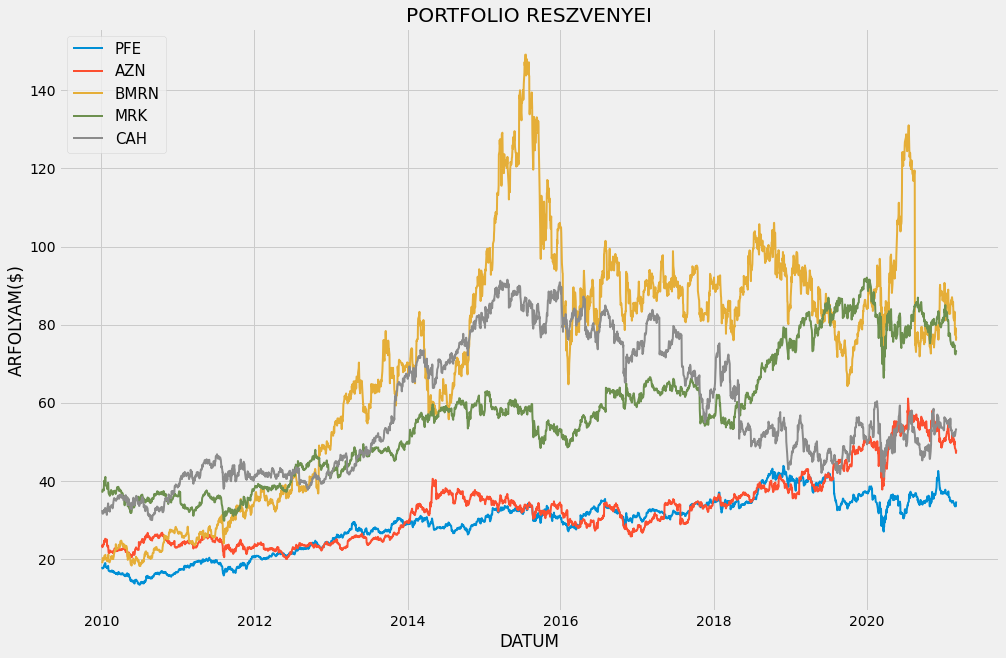

In [4]:
plt.figure(figsize=(15,10))

for t in dataframe.columns.values:
    plt.plot(dataframe[t], label = t, lw=2)
    plt.title('PORTFOLIO RESZVENYEI')


plt.xlabel('DATUM')
plt.ylabel('ARFOLYAM($)')
plt.legend(fontsize=15)
plt.show()

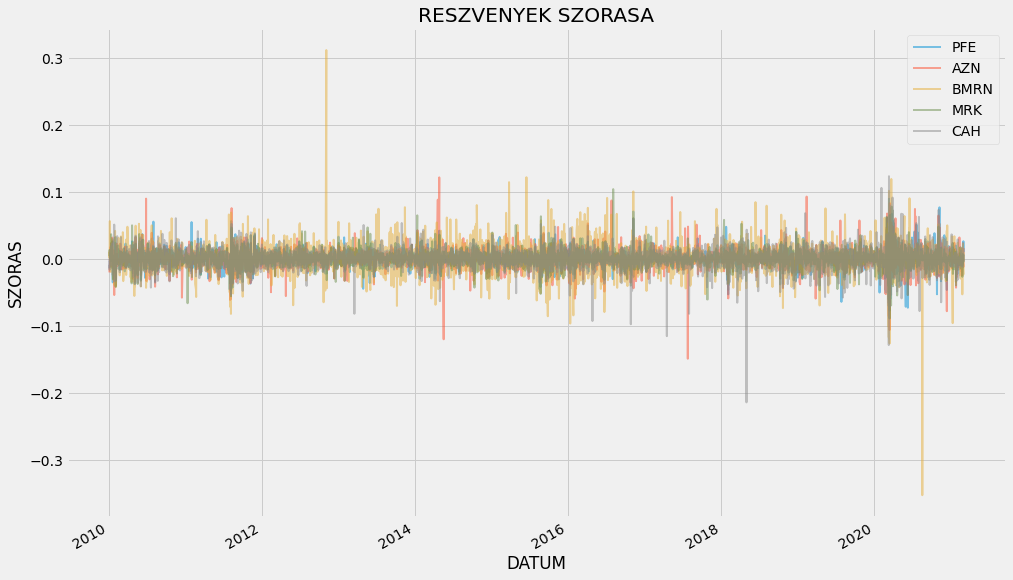

In [5]:
returns = dataframe.pct_change()
returns.plot(alpha=0.5, figsize=(15,10), lw=2)
plt.title('RESZVENYEK SZORASA')
plt.xlabel('DATUM')
plt.ylabel('SZORAS')
plt.show()

##### KOVARIANCIA MATRIX

In [6]:
# ~250 nap van egy evben
kov_matrix = returns.cov() * 250 
kov_matrix

,PFE,AZN,BMRN,MRK,CAH
PFE,0.041944,0.021377,0.027614,0.025538,0.025230
AZN,0.021377,0.057353,0.029820,0.020551,0.022334
BMRN,0.027614,0.029820,0.145696,0.027775,0.033916
MRK,0.025538,0.020551,0.027775,0.042670,0.024898
CAH,0.025230,0.022334,0.033916,0.024898,0.072430


##### KORRELACIOS MATRIX

In [20]:
korr_matrix = returns.corr()
korr_matrix

,PFE,AZN,BMRN,MRK,CAH
PFE,1.000000,0.436684,0.354065,0.604157,0.457994
AZN,0.436684,1.000000,0.326053,0.415938,0.347208
BMRN,0.354065,0.326053,1.000000,0.352881,0.330178
MRK,0.604157,0.415938,0.352881,1.000000,0.448109
CAH,0.457994,0.347208,0.330178,0.448109,1.000000


##### HA CSAK...

In [7]:
#Pfizer-be:
pfe_ret = np.sum(returns.loc[:, 'PFE'].mean()*250)*100
pfe_vol = np.sqrt(kov_matrix.iloc[0,0])*100
print('A PFE hozama: {:.2f}'.format(pfe_ret)+'%')
print('A PFE szorasa: {:.2f}'.format(pfe_vol)+'%')

print('----------------------')

#AstraZeneca-ba:
azn_ret = np.sum(returns.loc[:, 'AZN'].mean()*250)*100
azn_vol = np.sqrt(kov_matrix.iloc[1,1])*100
print('Az AZN hozama: {:.2f}'.format(azn_ret)+'%')
print('Az AZN szorasa: {:.2f}'.format(azn_vol)+'%')

print('----------------------')

#BioMarin-ba:
bmrn_ret = np.sum(returns.loc[:, 'BMRN'].mean()*250)*100
bmrn_vol = np.sqrt(kov_matrix.iloc[2,2])*100
print('A BMRN hozama: {:.2f}'.format(bmrn_ret)+'%')
print('A BMRN szorasa: {:.2f}'.format(bmrn_vol)+'%')

print('----------------------')

#Merck&Co-ba:
mrk_ret = np.sum(returns.loc[:, 'MRK'].mean()*250)*100
mrk_vol = np.sqrt(kov_matrix.iloc[3,3])*100
print('Az MRK hozama: {:.2f}'.format(mrk_ret)+'%')
print('Az MRK szorasa: {:.2f}'.format(mrk_vol)+'%')

print('----------------------')

#Cardinal Health-be:
cah_ret = np.sum(returns.loc[:, 'CAH'].mean()*250)*100
cah_vol = np.sqrt(kov_matrix.iloc[4,4])*100
print('A CAH hozama: {:.2f}'.format(cah_ret)+'%')
print('A CAH szorasa: {:.2f}'.format(cah_vol)+'%')

A PFE hozama: 7.97%
A PFE szorasa: 20.48%
----------------------
Az AZN hozama: 9.14%
Az AZN szorasa: 23.95%
----------------------
A BMRN hozama: 19.84%
A BMRN szorasa: 38.17%
----------------------
Az MRK hozama: 8.17%
Az MRK szorasa: 20.66%
----------------------
A CAH hozama: 8.02%
A CAH szorasa: 26.91%


##### PORTFOLIO HOZAM, SZORAS, SHARPE-MUTATO

In [181]:
weights = np.array([0.2, 0.1, 0.3, 0.3, 0.1]) #sulyok

port_variance = np.dot(weights.T, np.dot(kov_matrix, weights))

port_volatility = np.sqrt(port_variance)

port_return = np.sum(returns.mean() * weights) * 250

risk_free = 0.01 #1 szazalek

sharpe = ((port_return - risk_free) / port_volatility)

print('A portfolio eves hozama: {:.2f}'.format(port_return*100)+ '%')
print('A portfolio volatilitasa: {:.2f}'.format(port_volatility*100)+ '%')
print('Sharpe-mutato: {:.2f}'.format(sharpe))

A portfolio eves hozama: 11.65%
A portfolio volatilitasa: 20.05%
Sharpe-mutato: 0.48


##### PORTFOLIO HOZAM, SZORAS, SHARPE-MUTATO(MASHOGY)

In [93]:
mu = expected_returns.mean_historical_return(dataframe)
S = risk_models.sample_cov(dataframe)

ef = EfficientFrontier(mu, S)
sulyok = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose = True)

OrderedDict([('PFE', 0.06398), ('AZN', 0.21671), ('BMRN', 0.45136), ('MRK', 0.26795), ('CAH', 0.0)])
Expected annual return: 9.6%
Annual volatility: 23.3%
Sharpe Ratio: 0.32


(0.09556213266112926, 0.23257946574231447, 0.3248873773957673)

In [79]:
latest_prices = get_latest_prices(dataframe)
sulyok = cleaned_weights
da = DiscreteAllocation(sulyok, latest_prices, total_portfolio_value=6000)
allocation,leftover = da.lp_portfolio()
print('Discrete Allocation: ', allocation)
print('Funds Remaining($): {:.2f}'.format(leftover))

Discrete Allocation:  {'PFE': 11, 'AZN': 27, 'BMRN': 35, 'MRK': 22}
Funds Remaining($): 17.66
